In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, ShuffleSplit, StratifiedShuffleSplit

In [2]:
df = pd.read_csv('income_train.csv')
df.head(5)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,33,Local-gov,198183,Bachelors,13,Never-married,Prof-specialty,Not-in-family,White,Female,0,0,50,United-States,>50K
1,36,Private,86459,Assoc-voc,11,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,1887,50,United-States,>50K
2,58,Self-emp-not-inc,203039,9th,5,Separated,Craft-repair,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,21,Private,180190,Assoc-voc,11,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,46,United-States,<=50K
4,27,Private,279872,Some-college,10,Divorced,Other-service,Not-in-family,White,Male,0,0,40,United-States,<=50K


### Проанализируем данные <br>

### Переменные: <br>

<b> age </b> - возраст <br>
<b> workclass</b> - работодатель<br>
<b> fnlwgt</b> - final weight – примерная оценка количества людей, которое представляет каждая строка данных<br>
<b>education</b> - образование<br>
<b>education-num</b> - число лет, потраченных на обучение<br>
<b>marital-status</b> - семейное положение<br>
<b>occupation</b> - сфера деятельности<br>
<b>relationship</b> - родство<br>
<b>race</b> - раса<br>
<b>sex</b> - пол<br>
<b>capital-gain</b> - прирост капитала<br>
<b>capital-loss</b> - убыток капитала <br>
<b>hours-per-week</b> - кол-во рабочих часов в неделю<br>
<b>native-country</b> - место рождения<br>

In [3]:
df = df.replace(['>50K','<=50K'],[1,0])
display(df.describe().T)
df.isna().sum()

,count,mean,std,min,25%,50%,75%,max
age,26048.0,38.576513,13.642904,17.0,28.0,37.0,48.0,90.0
fnlwgt,26048.0,189759.180091,105232.885991,12285.0,117963.0,178263.5,237006.5,1484705.0
education-num,26048.0,10.080544,2.575202,1.0,9.0,10.0,12.0,16.0
capital-gain,26048.0,1053.617437,7230.800656,0.0,0.0,0.0,0.0,99999.0
capital-loss,26048.0,87.988828,403.629787,0.0,0.0,0.0,0.0,4356.0
hours-per-week,26048.0,40.388552,12.331139,1.0,40.0,40.0,45.0,99.0
income,26048.0,0.240709,0.427522,0.0,0.0,0.0,0.0,1.0


age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64

Явных пропущенных значений нет.

In [4]:
d_gain = df[df['capital-gain']!=0].shape[0]/df.shape[0]
print(f'Всего {round(d_gain*100,1)}% представителей инвестировали и получали положительный доход')

d_loss = df[df['capital-loss']!=0].shape[0]/df.shape[0]
print(f'Всего {round(d_loss*100,1)}% представителей инвестировали и теряли средства')

Всего 8.2% представителей инвестировали и получали положительный доход
Всего 4.7% представителей инвестировали и теряли средства


In [5]:
num_cols = ['age','education-num','capital-gain','capital-loss','hours-per-week','fnlwgt']
cat_cols = ['workclass','education','marital-status','occupation','relationship','race','sex','native-country']
target_col = ['income']

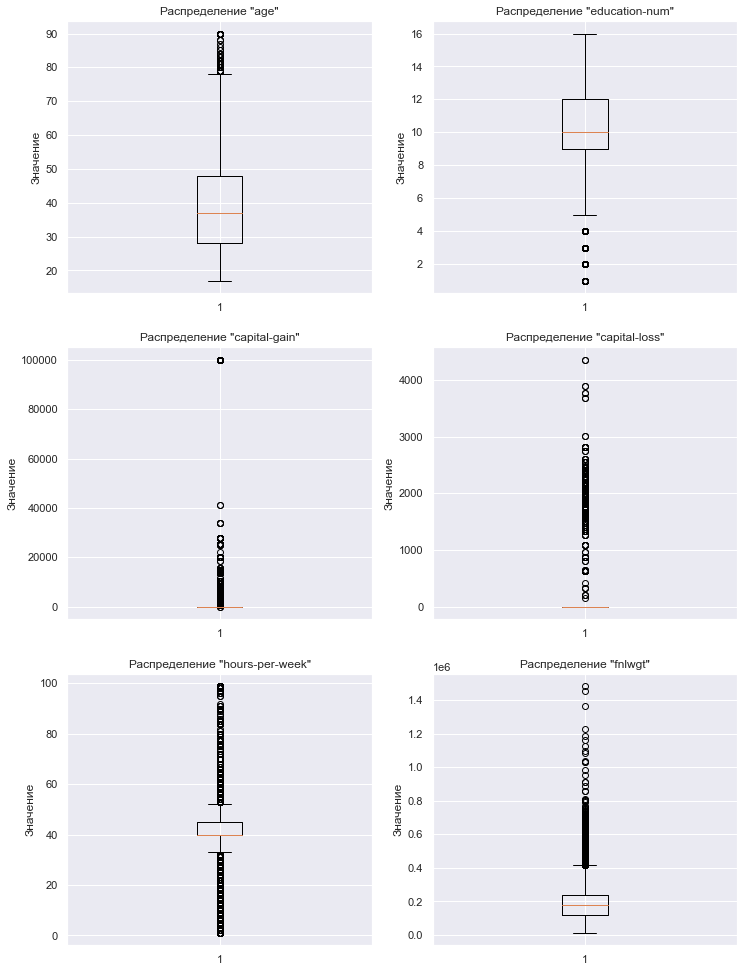

In [6]:
sns.set()
fig = plt.figure(figsize=(12,17))
for i,col in enumerate(num_cols):
    plt.subplot(3,2,i+1)
    plt.boxplot(df[col])
    plt.grid(True)
    plt.ylabel('Значение')
    plt.title(f'Распределение "{col}"')

В данных очень много выбросов! Линейные модели в таком случае не очень хороши.

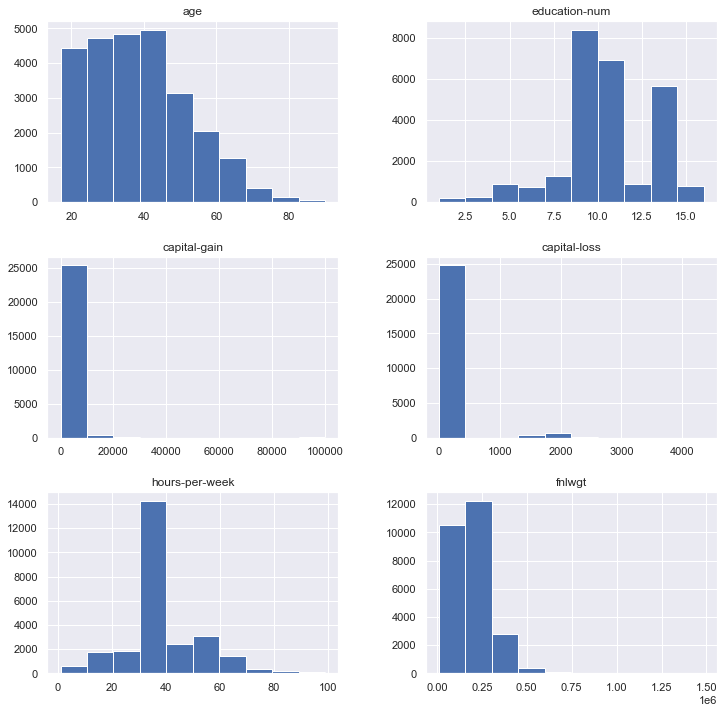

In [7]:
df[num_cols].hist(figsize=(12,12));

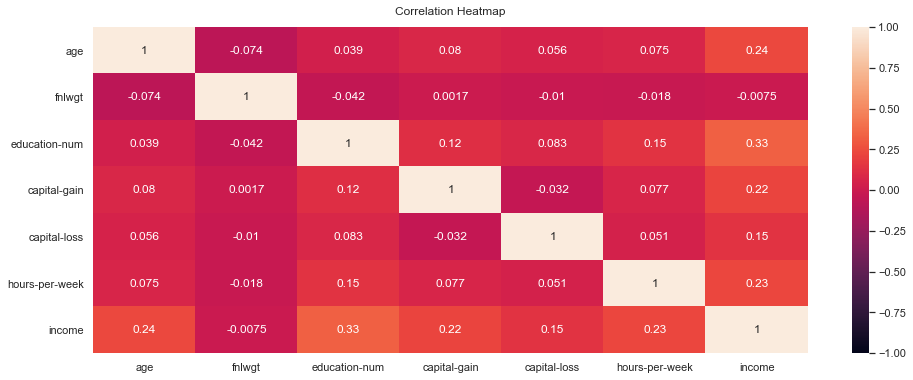

In [8]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

'fnlwgt' не коррелирует с доходом, значит эту переменную можно просто выбросить.

In [9]:
df = df.drop('fnlwgt',axis=1)

### Анализ категориальных переменных

In [10]:
for col in cat_cols:
    print(f'Колонка: {col}')
    display(df[col].value_counts())

Колонка: workclass


Private             18118
Self-emp-not-inc     2043
Local-gov            1706
?                    1447
State-gov            1044
Self-emp-inc          904
Federal-gov           769
Without-pay            10
Never-worked            7
Name: workclass, dtype: int64

Колонка: education


HS-grad         8416
Some-college    5806
Bachelors       4302
Masters         1354
Assoc-voc       1109
11th             950
Assoc-acdm       869
10th             750
7th-8th          505
Prof-school      460
9th              399
Doctorate        336
12th             335
5th-6th          271
1st-4th          145
Preschool         41
Name: education, dtype: int64

Колонка: marital-status


Married-civ-spouse       12026
Never-married             8557
Divorced                  3523
Separated                  816
Widowed                    785
Married-spouse-absent      322
Married-AF-spouse           19
Name: marital-status, dtype: int64

Колонка: occupation


Prof-specialty       3312
Craft-repair         3278
Exec-managerial      3228
Adm-clerical         3044
Sales                2921
Other-service        2628
Machine-op-inspct    1624
?                    1454
Transport-moving     1280
Handlers-cleaners    1097
Farming-fishing       801
Tech-support          739
Protective-serv       513
Priv-house-serv       123
Armed-Forces            6
Name: occupation, dtype: int64

Колонка: relationship


Husband           10603
Not-in-family      6603
Own-child          4049
Unmarried          2744
Wife               1246
Other-relative      803
Name: relationship, dtype: int64

Колонка: race


White                 22221
Black                  2525
Asian-Pac-Islander      846
Amer-Indian-Eskimo      240
Other                   216
Name: race, dtype: int64

Колонка: sex


Male      17403
Female     8645
Name: sex, dtype: int64

Колонка: native-country


United-States                 23300
Mexico                          529
?                               458
Philippines                     163
Germany                         105
Canada                           99
Puerto-Rico                      92
El-Salvador                      86
India                            79
Cuba                             76
England                          76
Jamaica                          68
South                            67
Dominican-Republic               62
Vietnam                          62
Italy                            59
China                            57
Columbia                         53
Japan                            51
Guatemala                        51
Poland                           46
Taiwan                           40
Haiti                            38
Portugal                         31
Iran                             31
Nicaragua                        27
Peru                             26
France                      

Обратим внимание! В некоторых колонках workclass, occupation, native-country есть "?" - пропущенные значения. 

In [11]:
print(f"Всего пропущенных строк: {df[df.eq('?').any(axis=1)].shape[0]}")
print(f"А это {round(df[df.eq('?').any(axis=1)].shape[0]/df.shape[0]*100)}% наших данных")

Всего пропущенных строк: 1891
А это 7% наших данных


С чем могут быть связаны пропуски в 'occupation'? Возможно, с тем, что человек никогда не работал. Тогда его 'workclass' будет равен 'never-worked'.

In [12]:
df[df['occupation'] == '?']['workclass'].value_counts()

?               1447
Never-worked       7
Name: workclass, dtype: int64

Увы, всего лишь 7 пропусков в профессии связаны с тем, что человек никогда не работал. Остальные пропуски совпадают.

In [13]:
df[df['workclass'] == '?']['occupation'].value_counts()

?    1447
Name: occupation, dtype: int64

Все пропущенные значения 'workclass' соответствуют пропущенным значениям в 'occupation'. Можно их заменять на моду, можно просто убрать, а можно оставить, как есть, создав отдельную категорию для пропущенных значений. 

In [14]:
mask= df['workclass']=='Never-worked'
df.loc[mask,'occupation'] = 'Never-worked'

df['occupation'] = df['occupation'].replace('?','Other')
df['workclass'] = df['workclass'].replace('?','Other')

In [15]:
df.loc[df['workclass']=='Never-worked','hours-per-week'] = 0

В категории "workclass" нам не принципиально, никогда человек не работал или он работал бесплатно.

In [16]:
display(df.groupby('workclass').mean().income)
df['workclass'] = df['workclass'].replace('Never-worked','Without-pay')

workclass
Federal-gov         0.391417
Local-gov           0.297186
Never-worked        0.000000
Other               0.102972
Private             0.218678
Self-emp-inc        0.557522
Self-emp-not-inc    0.277533
State-gov           0.268199
Without-pay         0.000000
Name: income, dtype: float64

Пропуски страны рождения можно просто заменить модой. Это не очень критично, т.к. подавляющее количество человек у нас из США.

In [17]:
df['native-country'] = df['native-country'].replace('?',df['native-country'].mode()[0])

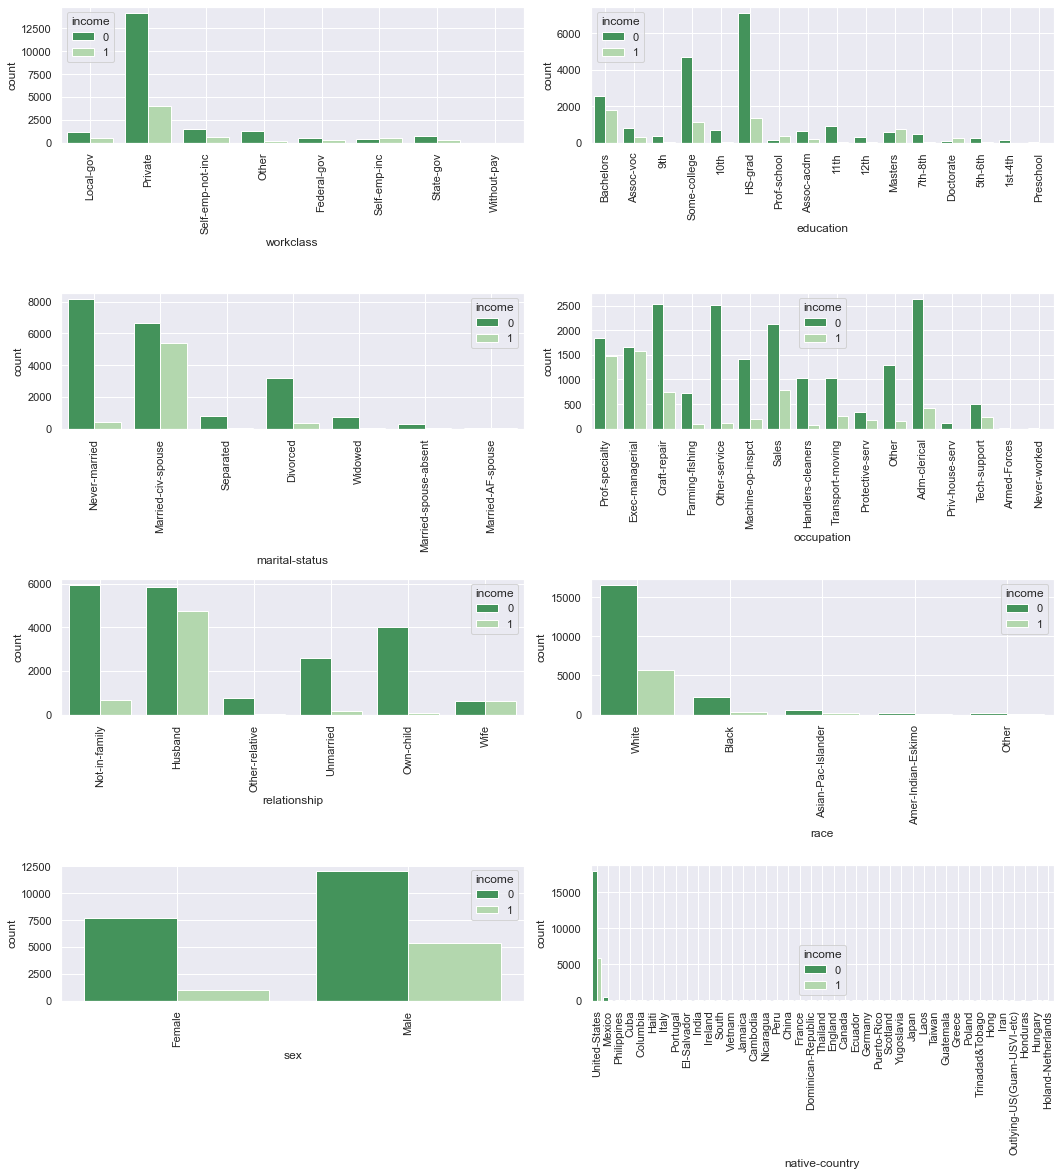

In [18]:
fig = plt.figure(figsize=(15,15))
for i,col in enumerate(cat_cols):
    plt.subplot(4,2,i+1)
    plt.tight_layout()
    sns.countplot(df[col],hue=df['income'], palette='Greens_r')
    plt.grid(True)
    plt.xlabel(cat_cols[i])
    plt.xticks(rotation=90)

### Education

Количество лет, потраченных на обучение, и степень образования по сути означают одно и то же. Что-то можно убрать. Всех школьников и дошкольников можно собрать воедино.

In [19]:
df['education'] = df['education'].replace(['11th', '9th', '7th-8th', '5th-6th', '10th', '1st-4th', 'Preschool', '12th'], 'School')

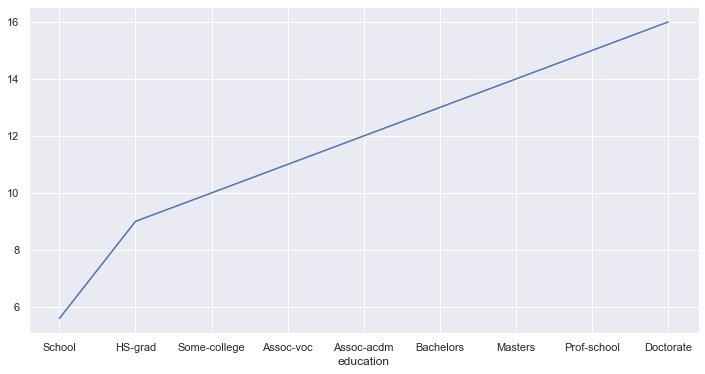

In [20]:
df.groupby('education')['education-num'].mean().sort_values().plot(figsize=(12,6));

In [21]:
df= df.drop(['education-num'],axis=1)

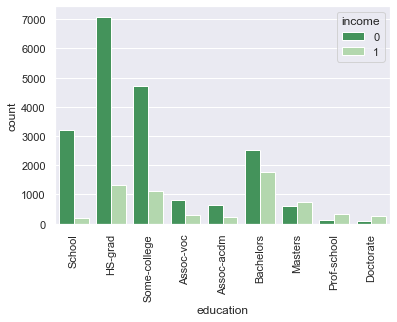

In [22]:
order_list = ['School', 'HS-grad', 'Some-college', 'Assoc-voc','Assoc-acdm', 'Bachelors', 'Masters', 'Prof-school', 'Doctorate'] 

sns.countplot(df['education'],hue=df['income'], palette='Greens_r', order=order_list)
plt.xticks(rotation=90);

### Native-country
Большинство представителей из США. Можно добавить дамми-переменную, из США ли человек, чтобы уменьшить количество переменных после кодировки.

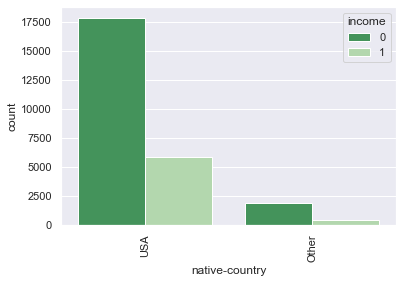

In [23]:
df['native-country'] = np.where(df['native-country'] == 'United-States','USA','Other')
sns.countplot(df['native-country'],hue=df['income'], palette='Greens_r')
plt.xticks(rotation=90);

In [24]:
X = df.drop('income',axis=1)
y = df['income']

### Кодировка и деление на тестовую и обучающую выборку

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True,stratify=y)
X_train.sample(5)

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
19101,32,Self-emp-inc,Some-college,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,55,USA
25363,19,Private,HS-grad,Never-married,Farming-fishing,Own-child,White,Male,0,0,40,USA
5046,76,Local-gov,HS-grad,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,15,USA
2297,34,Private,School,Divorced,Other-service,Unmarried,White,Female,0,0,38,USA
22629,38,Local-gov,HS-grad,Never-married,Craft-repair,Not-in-family,White,Male,0,1876,40,Other


Лес не требует масштабирования => обычный OneHotEncoder подойдет. Для образования можно использовать LabelEncoder, можно очевидным образом проранжировать.

In [26]:
df.groupby('education').mean()['income'].sort_values()

education
School          0.059776
HS-grad         0.158032
Some-college    0.191182
Assoc-acdm      0.250863
Assoc-voc       0.268711
Bachelors       0.411669
Masters         0.555391
Prof-school     0.736957
Doctorate       0.741071
Name: income, dtype: float64

In [27]:
educ_map = {'School':0,'HS-grad':1,'Some-college':2, 'Assoc-acdm':3,'Assoc-voc':4,'Bachelors':5,'Masters':6,'Prof-school':7,'Doctorate':8}

X_train['education'] = X_train['education'].map(educ_map)
X_test['education'] = X_test['education'].map(educ_map)

In [28]:
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder
import category_encoders as ce
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

no_change = ['age','hours-per-week','capital-gain','capital-loss','education']
oh_enc = ['workclass','marital-status','occupation','relationship','race','sex','native-country']
CT = ColumnTransformer([
        ("_", 'passthrough', no_change),
        ("ohe", OneHotEncoder(), oh_enc)
        ], sparse_threshold=0)


X_train_CT = CT.fit_transform(X_train)
X_test_CT = CT.transform(X_test)

In [29]:
pd.DataFrame(X_train_CT, columns=CT.get_feature_names_out()).head()

,___age,___hours-per-week,___capital-gain,___capital-loss,___education,ohe__workclass_Federal-gov,ohe__workclass_Local-gov,ohe__workclass_Other,ohe__workclass_Private,ohe__workclass_Self-emp-inc,...,ohe__relationship_Wife,ohe__race_Amer-Indian-Eskimo,ohe__race_Asian-Pac-Islander,ohe__race_Black,ohe__race_Other,ohe__race_White,ohe__sex_Female,ohe__sex_Male,ohe__native-country_Other,ohe__native-country_USA
0,55.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,19.0,40.0,15024.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
2,26.0,40.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,21.0,40.0,2176.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
4,30.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0


In [81]:
rfc = RandomForestClassifier(n_jobs=-1,random_state=1)
rfc.fit(X_train_CT,y_train)
display(rfc.score(X_train_CT,y_train))
rfc.score(X_test_CT, y_test)

0.9822300224867

0.8474728087012157

In [82]:
gb = GradientBoostingClassifier(random_state=1)
gb.fit(X_train_CT,y_train)
display(gb.score(X_train_CT,y_train))
gb.score(X_test_CT,y_test)

0.8704546701036582

0.8650031989763276

### Поиск по сетке для бустинга

In [76]:
params = {'learning_rate': [0.1,0.01,0.05,0,15,0.2,0.25],
          'subsample': [1,0.8,0.9,0.75],
          'min_samples_split': [2,5,7,10,20,50,100,150],
          'max_features': ['auto',None]
         }

gb = GradientBoostingClassifier(random_state=1, n_estimators=250)
grid = GridSearchCV(gb,params,n_jobs=-1, cv=StratifiedShuffleSplit(n_splits=5,random_state=1),verbose=1)
grid.fit(X_train_CT, y_train)
print(f'Средняя правильность на кроссвалидационных тестах: {round(grid.best_score_,5)}')
print(f'Параметры лучшей модели: {grid.best_estimator_}')

Fitting 5 folds for each of 448 candidates, totalling 2240 fits
Средняя правильность на кроссвалидационных тестах: 0.87215
Параметры лучшей модели: GradientBoostingClassifier(learning_rate=0.2, max_features='auto',
                           min_samples_split=50, n_estimators=250,
                           random_state=1, subsample=1)


In [30]:
gb = GradientBoostingClassifier(subsample=1,n_estimators=250, min_samples_split=50,max_features='auto',learning_rate=0.2)
gb.fit(X_train_CT,y_train)

print(f'Результат на тренировочном наборе: {round(gb.score(X_train_CT,y_train),4)}')
print(f'Результат на тестовом наборе: {round(gb.score(X_test_CT,y_test),4)}')

Результат на тренировочном наборе: 0.8884
Результат на тестовом наборе: 0.8691


### Поиск по сетке для случайного леса

In [413]:
from sklearn.metrics import roc_auc_score

parameters = {'max_features': [1, 3, 5, 7, 8, 9, 10, 13 ,15], 'min_samples_leaf': [1, 3, 4, 5, 6, 7, 8], 'max_depth': [15,20,25,30,35,40,45,50,55], 'criterion': ['gini','enthropy']}
rfc = RandomForestClassifier(n_estimators=100, random_state=1, 
                             n_jobs=-1)
grid = GridSearchCV(rfc, parameters, n_jobs=-1, cv=StratifiedShuffleSplit(n_splits=5,random_state=1), verbose=1)
grid.fit(X_train_CT, y_train)
print(f'Средняя правильность на кроссвалидационных тестах: {round(grid.best_score_,4)}')
print(f'Параметры лучшей модели: {grid.best_estimator_}')

Fitting 5 folds for each of 1134 candidates, totalling 5670 fits
Средняя правильность на кроссвалидационных тестах: 0.8602


In [31]:
rfc = RandomForestClassifier(max_depth=20,max_features=7,min_samples_leaf=3,n_jobs=-1)
rfc.fit(X_train_CT,y_train)
print(f'Результат на тренировочном наборе: {round(rfc.score(X_train_CT,y_train),4)}')
print(f'Результат на тестовом наборе: {round(rfc.score(X_test_CT,y_test),4)}')

Результат на тренировочном наборе: 0.8876
Результат на тестовом наборе: 0.8618


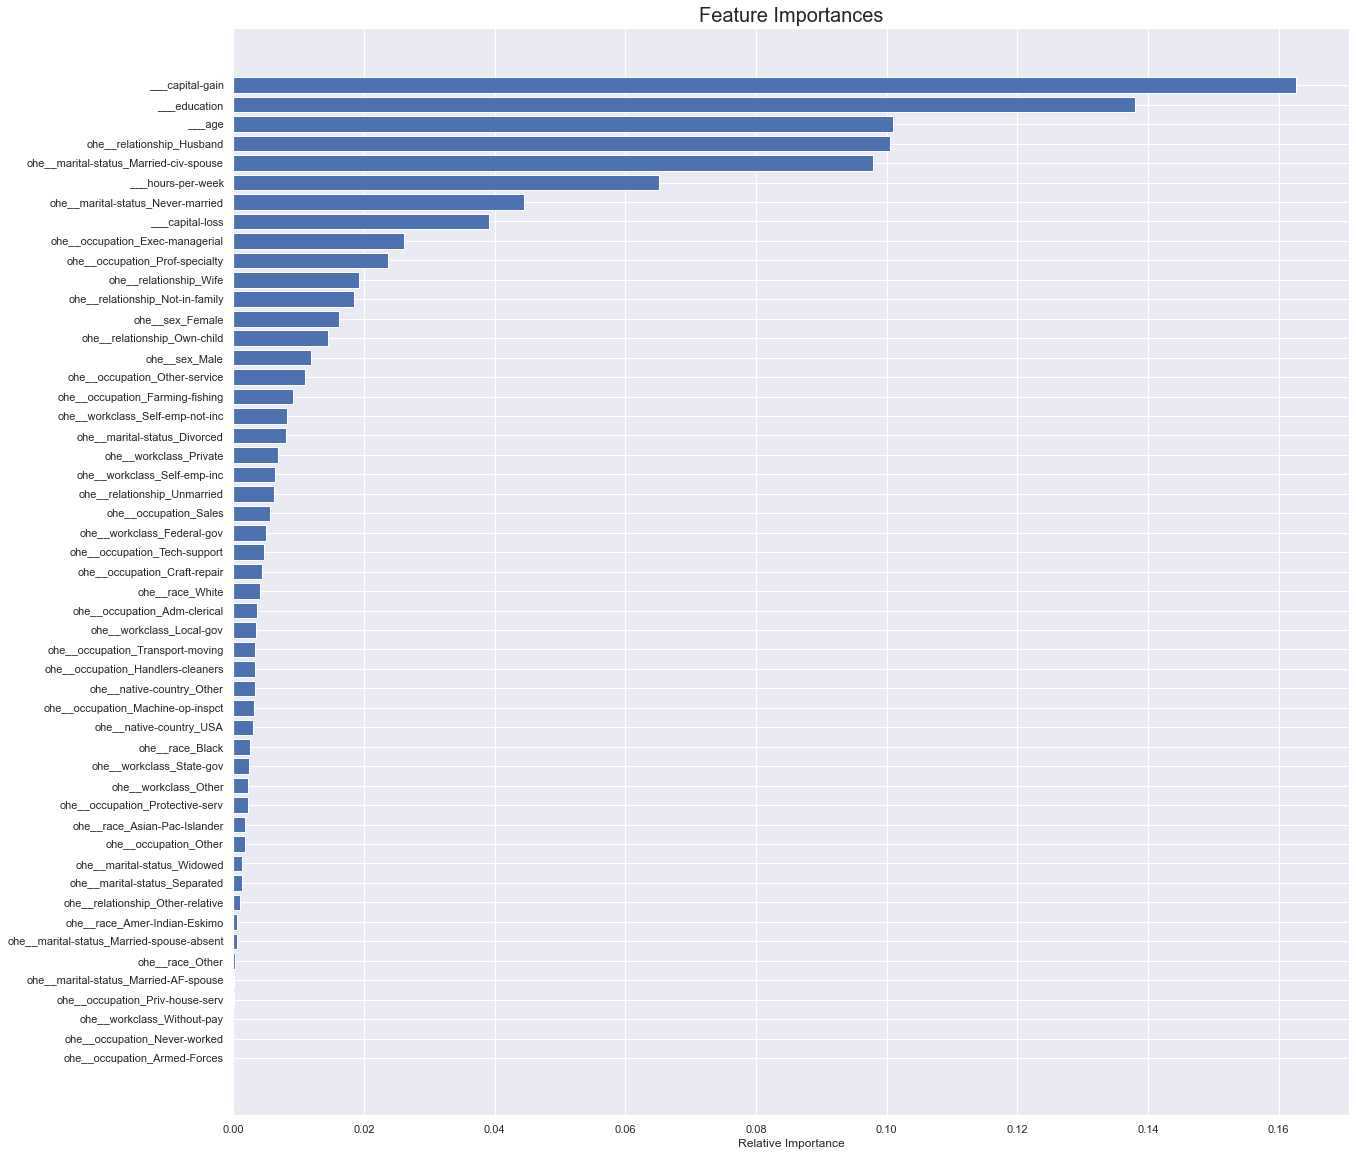

In [32]:
features = CT.get_feature_names_out()
importances = rfc.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(20,20))
plt.title('Feature Importances',size=20)
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

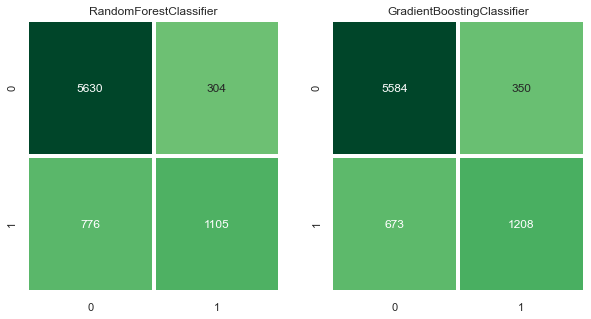

In [33]:
from sklearn.metrics import confusion_matrix, classification_report

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))

y_pred_rfc = rfc.predict(X_test_CT)

sns.heatmap(confusion_matrix(y_test,y_pred_rfc),annot=True, fmt='g', cbar=None,cmap="YlGn",linewidths=3, center=0,ax=ax1);
ax1.set_title('RandomForestClassifier')
y_pred_gb = gb.predict(X_test_CT)
ax2.set_title('GradientBoostingClassifier')
sns.heatmap(confusion_matrix(y_test,y_pred_gb),annot=True, fmt='g', cbar=None,cmap="YlGn",linewidths=3, center=0,ax=ax2);


In [34]:
print(classification_report(y_test,y_pred_rfc))
print(classification_report(y_test,y_pred_gb))

              precision    recall  f1-score   support

           0       0.88      0.95      0.91      5934
           1       0.78      0.59      0.67      1881

    accuracy                           0.86      7815
   macro avg       0.83      0.77      0.79      7815
weighted avg       0.86      0.86      0.85      7815

              precision    recall  f1-score   support

           0       0.89      0.94      0.92      5934
           1       0.78      0.64      0.70      1881

    accuracy                           0.87      7815
   macro avg       0.83      0.79      0.81      7815
weighted avg       0.86      0.87      0.86      7815



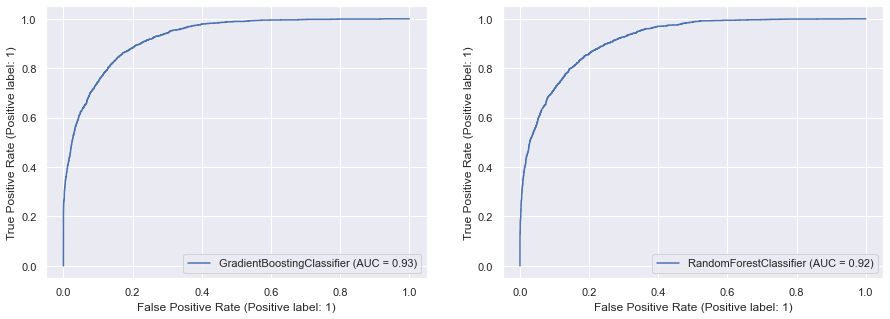

In [35]:
from sklearn.metrics import RocCurveDisplay

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(15, 5))
RocCurveDisplay.from_estimator(gb, X_test_CT, y_test,ax=ax1);
RocCurveDisplay.from_estimator(rfc, X_test_CT, y_test,ax=ax2);

### Подгружаем тестовые данные

In [36]:
test_data = pd.read_csv('test.csv')

test_data = test_data.replace(['>50K','<=50K'],[1,0])
display(test_data.describe().T)

test_data = test_data.drop('fnlwgt',axis=1)
test_data= test_data.drop(['education-num'],axis=1)

,count,mean,std,min,25%,50%,75%,max
age,6513.0,38.602180,13.631572,17.0,28.0,37.0,48.0,90.0
fnlwgt,6513.0,189855.100415,106816.857134,14878.0,117507.0,179013.0,237317.0,1268339.0
education-num,6513.0,10.081222,2.562967,1.0,9.0,10.0,12.0,16.0
capital-gain,6513.0,1173.759711,7973.158945,0.0,0.0,0.0,0.0,99999.0
capital-loss,6513.0,84.564256,400.290275,0.0,0.0,0.0,0.0,4356.0
hours-per-week,6513.0,40.633042,12.411387,1.0,40.0,40.0,45.0,99.0


In [37]:
mask= test_data['workclass']=='Never-worked'
test_data.loc[mask,'occupation'] = 'Never-worked'

test_data['occupation'] = test_data['occupation'].replace('?','Other')
test_data['workclass'] = test_data['workclass'].replace('?','Other')

test_data['workclass'] = test_data['workclass'].replace('Never-worked','Without-pay')

test_data['native-country'] = test_data['native-country'].replace('?',test_data['native-country'].mode()[0])
test_data['education'] = test_data['education'].replace(['11th', '9th', '7th-8th', '5th-6th', '10th', '1st-4th', 'Preschool', '12th'], 'School')
test_data['native-country'] = np.where(test_data['native-country'] == 'United-States','USA','Other')

In [38]:
educ_map = {'School':0,'HS-grad':1,'Some-college':2, 'Assoc-acdm':3,'Assoc-voc':4,'Bachelors':5,'Masters':6,'Prof-school':7,'Doctorate':8}
test_data['education'] = test_data['education'].map(educ_map)

### все строки сохранены

In [44]:
test_data_CT = CT.transform(test_data) 

In [40]:
gb = GradientBoostingClassifier(subsample=1,n_estimators=250, min_samples_split=50,max_features='auto',learning_rate=0.2)
gb.fit(X_train_CT,y_train)
y_pred = gb.predict(test_data_CT) # предсказанные значения
